In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline


sns.set_style("white")
plt.style.use('seaborn')
# sns.set_palette("white")

In [2]:
df_raw = pd.read_csv('../data/ny_ev_registrations_public.csv')
df_raw = df_raw[(df_raw.Technology == 'BEV')]
df_raw['Vehicle Name'].value_counts()
df_raw.head()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,DMV ID,DMV Snapshot,ZIP Code,State,Registration Valid Date,Registration Expiration Date,VIN Prefix,VIN Model Year,Vehicle Name,Technology
0,39,NY DATA.NY.GOV (4/2/2020),10583,NY,3/27/2019,12/31/2020,5YJ3E1EB,J,Tesla Model 3,BEV
1,39,NY DATA.NY.GOV (4/2/2020),10583,NY,12/24/2018,12/23/2020,5YJ3E1EB,J,Tesla Model 3,BEV
2,39,NY DATA.NY.GOV (4/2/2020),10583,NY,12/4/2018,12/3/2020,5YJ3E1EB,J,Tesla Model 3,BEV
3,39,NY DATA.NY.GOV (4/2/2020),10583,NY,12/1/2018,11/30/2020,5YJ3E1EB,J,Tesla Model 3,BEV
4,39,NY DATA.NY.GOV (4/2/2020),10583,NY,11/29/2018,11/28/2020,5YJ3E1EB,J,Tesla Model 3,BEV


In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

Year
2011-01-01       2176.0
2012-01-01       4362.0
2012-12-31       6869.0
2013-07-08       6875.0
2013-07-17       6886.0
                ...    
2022-05-28    1476477.0
2022-05-29    1476501.0
2022-05-30    1476538.0
2022-05-31    1476682.0
2022-06-01    1476683.0
Name: Registered Vehicles, Length: 3123, dtype: float64

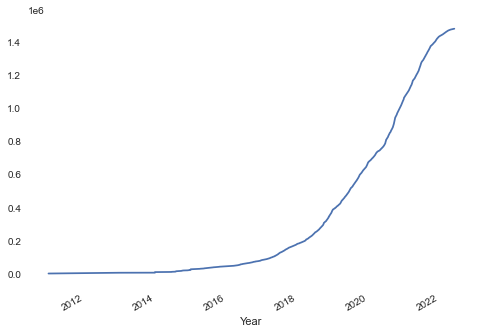

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df = df['Registered Vehicles'].cumsum()
sns.set_style(style='white')
df.plot()
df

In [5]:
# df = pd.DataFrame(years['Registered Vehicles'])
# df = df.set_axis(pd.to_datetime(years['Year']))
# df = df.sort_values(by=['Year'], ascending = True)
# df = df.astype(float)
# df['Registered Vehicles'].cumsum()
# df.plot()
# df

In [6]:
# Sum of vehicles registered in NY as of June 2022
# df['Registered Vehicles'].sum()

## **RESAMPLING

In [7]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [8]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

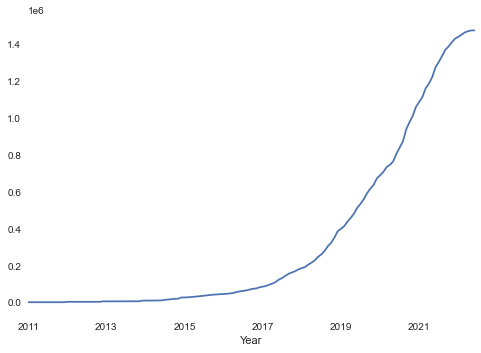

In [9]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

## Testing 

In [10]:
adtest = adfuller(df)
display(adtest)

(-3.7508260192859324,
 0.003452458357067061,
 9,
 128,
 {'1%': -3.4825006939887997,
  '5%': -2.884397984161377,
  '10%': -2.578960197753906},
 2407.8874827462682)

## Modeling

In [11]:
# Splitting Training and Testing data; using after 2019 as test

train = df['2017-06-30':'2020-12-31']
test = df['2021-06-30':]
combined = df

test

Year
2021-06-30    1276189.0
2021-07-31    1305041.0
2021-08-31    1337252.0
2021-09-30    1371459.0
2021-10-31    1389304.0
2021-11-30    1412038.0
2021-12-31    1431990.0
2022-01-31    1441682.0
2022-02-28    1454165.0
2022-03-31    1465918.0
2022-04-30    1472502.0
2022-05-31    1476682.0
2022-06-30    1476683.0
Freq: M, Name: Registered Vehicles, dtype: float64

In [12]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1261.653, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1237.559, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=969.736, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1236.709, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.631 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   43
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -481.868
Date:         

### The best model is :  ARIMA (3,0,0) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0445      0.004    272.808      0.000       1.037       1.052
ma.L1          0.6397      0.141      4.522      0.000       0.362       0.917
sigma2      7.612e+07   2.22e-10   3.43e+17      0.000    7.61e+07    7.61e+07


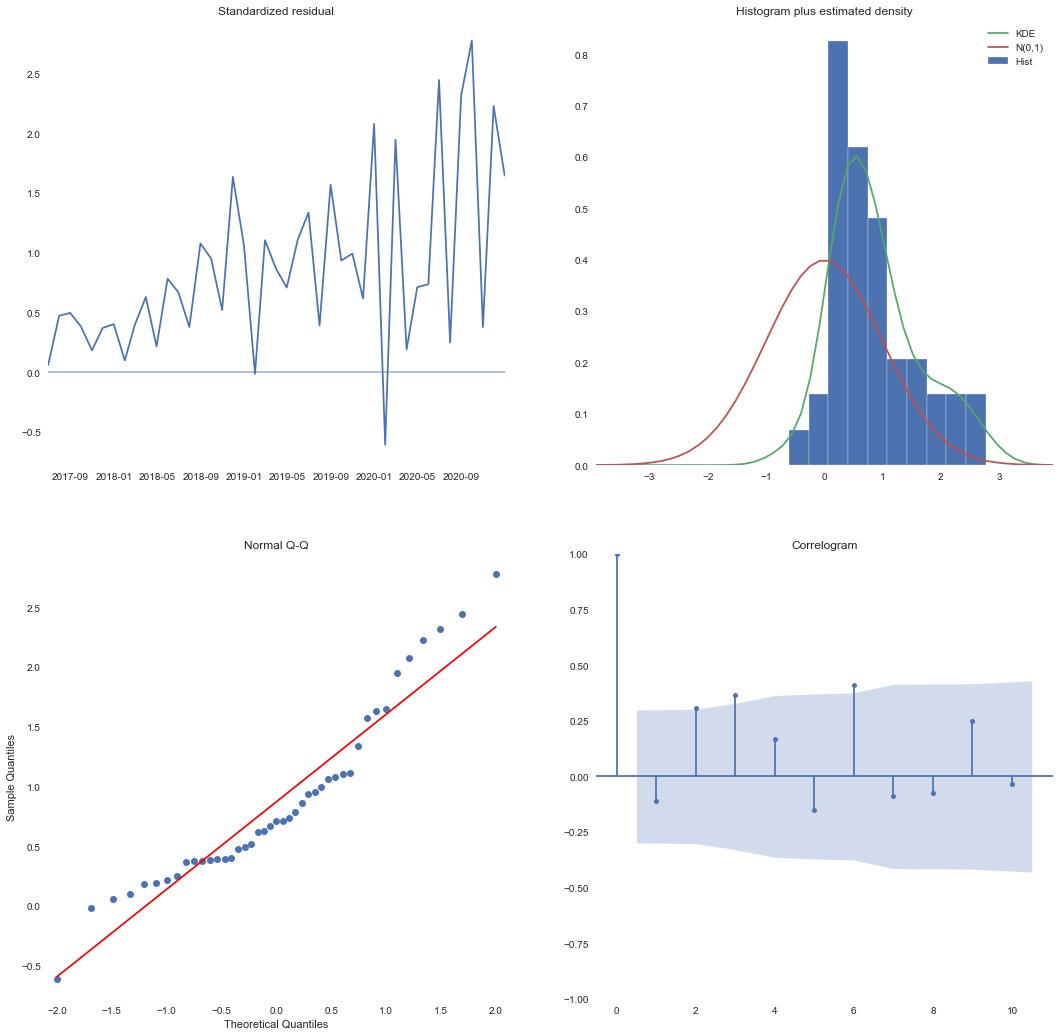

In [13]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(1,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [14]:
pred = output.get_prediction(start=pd.to_datetime('2020-12-31'), end=pd.to_datetime('2022-06-30'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2020-12-31,1.042426e+06,1.076627e+06
2021-01-31,1.093204e+06,1.127405e+06
2021-02-28,1.126167e+06,1.193156e+06
2021-03-31,1.166194e+06,1.256232e+06
2021-04-30,1.210159e+06,1.319954e+06
2021-05-31,1.257336e+06,1.385250e+06
2021-06-30,1.307468e+06,1.452591e+06
2021-07-31,1.360467e+06,1.522288e+06
2021-08-31,1.416321e+06,1.594583e+06
2021-09-30,1.475065e+06,1.669685e+06


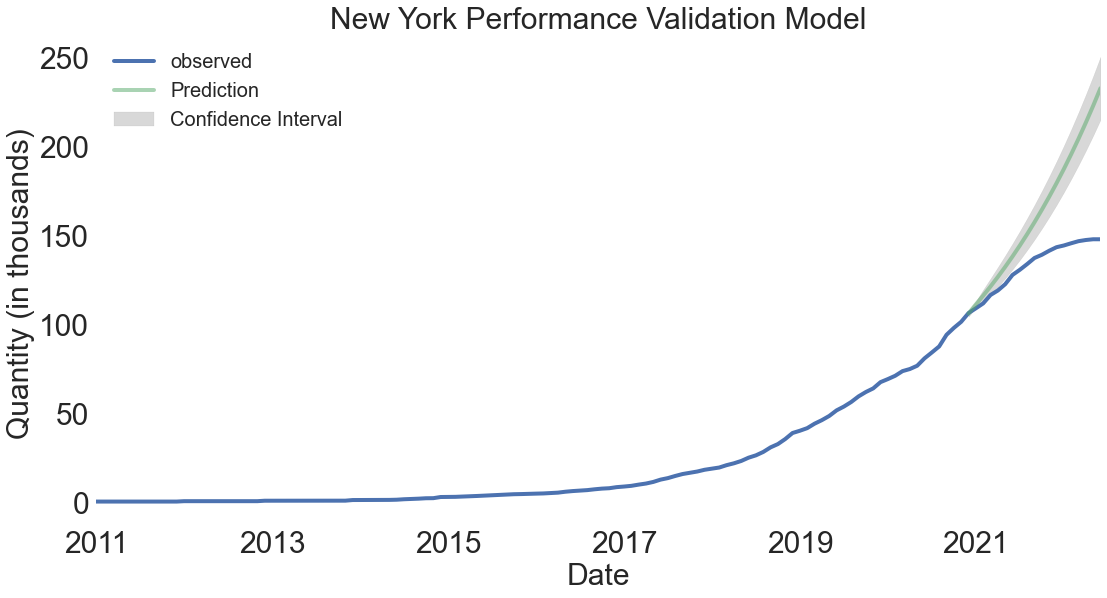

In [21]:


rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in thousands) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e4
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('New York Performance Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

## Forecasting NY

In [16]:
# Beginning our forecasting for next 3 years (36 months)
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(combined, 
                                        order=(1,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


full_output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0445      0.004    272.808      0.000       1.037       1.052
ma.L1          0.6397      0.141      4.522      0.000       0.362       0.917
sigma2      7.612e+07   2.22e-10   3.43e+17      0.000    7.61e+07    7.61e+07


In [17]:
forecast = full_output.get_forecast(36)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

,lower,upper,prediction
2022-07-31,1.474724e+06,1.513770e+06,1.494247e+06
2022-08-31,1.488508e+06,1.570883e+06,1.529695e+06
2022-09-30,1.510534e+06,1.621435e+06,1.565985e+06
2022-10-31,1.535909e+06,1.670361e+06,1.603135e+06
2022-11-30,1.563492e+06,1.718841e+06,1.641166e+06
2022-12-31,1.592808e+06,1.767392e+06,1.680100e+06
2023-01-31,1.623611e+06,1.816304e+06,1.719958e+06
2023-02-28,1.655759e+06,1.865762e+06,1.760761e+06
2023-03-31,1.689167e+06,1.915896e+06,1.802532e+06
2023-04-30,1.723780e+06,1.966807e+06,1.845293e+06


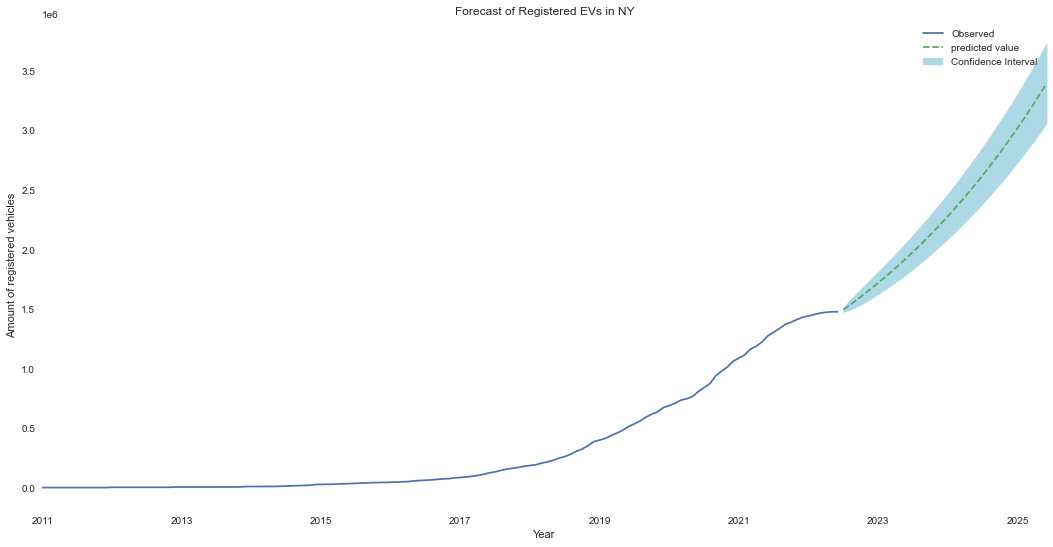

In [18]:
fig, ax = plt.subplots()
combined.plot(ax=ax,label='Observed')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='lightblue',
                label='Confidence Interval')
scale_y = 1e6
ax.legend() 
plt.ylabel("Amount of registered vehicles")
plt.title('Forecast of Registered EVs in NY')
plt.show()

In [19]:
future_prediction['prediction'].sum()

83507630.58610502

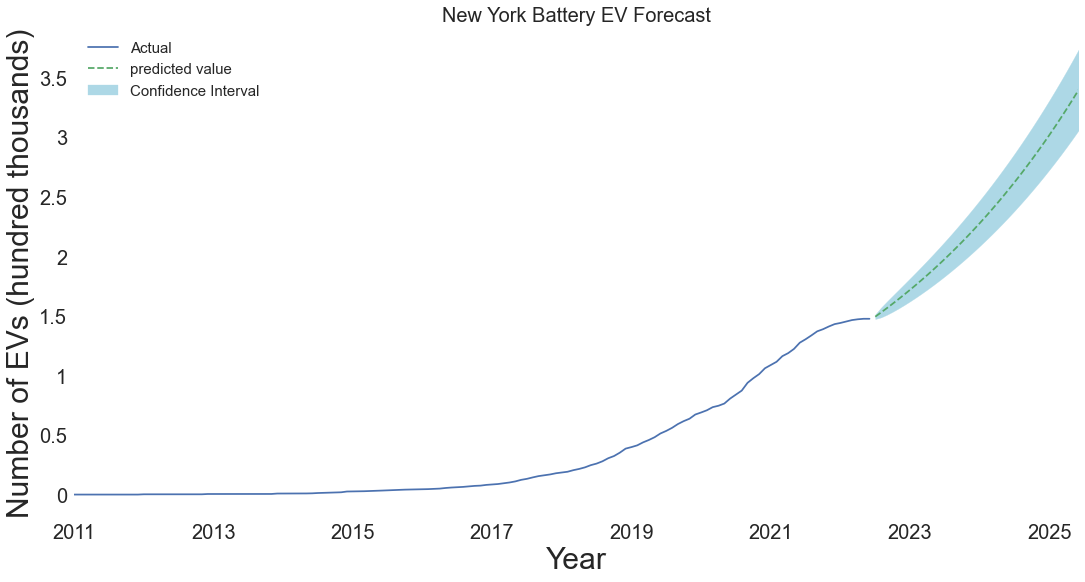

In [20]:
sns.set_style(style='white')
fig, ax = plt.subplots()
combined.plot(ax=ax,label='Actual')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'], color = 'lightblue',
                label='Confidence Interval')


ax.set_xlabel('Year',fontsize=30)
plt.xticks(fontsize=20)
ax.set_ylabel('Number of EVs (hundred thousands)',fontsize=30)
plt.yticks(fontsize=20)

# scale_y = 1e5
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('New York Battery EV Forecast',fontsize=20)
plt.legend(fontsize = 15)
plt.show()